In [2]:
# 采用Transfer Learning,对VGG19进行特征抽取
# 即对VGG19中Flatten后面的神经层全部去掉，换上我们自己的神经层，这个行为叫做特征抽取
# 注：VGG19中，前面的多重卷积层和池化层对图像特征已做了很好的提取，此部分可以直接使用

# 通过代码来初始化一个VGG19网络实例
import keras
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 下载vgg19模型预训练权重，将之放到~/.keras/model/下面，
# 这样在keras导入vgg16的时候就不会联网下载

# weight参数告诉程序将网络的卷积层和max pooling层对应的参数传递过来，
# 并将它们初始化成对应的网络层次
# include_top表示是否也要把Flatten()后面的网络层也下载过来
# input_shape告诉网络，我们输入图片的大小是150*150像素，每个像素由[R, G, B]三个值表示
conv_base = VGG19(weights="imagenet", include_top=False,input_shape = (150,150,3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
# 接下来我们将把自己的图片读进来，
# 把图片喂给上面网络，让它把图片的隐含信息给抽取出来
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "C:/Users/hh/Desktop/Kaggle/2.0 CatdogNet/input/train3"
train_dir = os.path.join(base_dir,"train")
validation_dir = os.path.join(base_dir,"validation")
test_dir = os.path.join(base_dir,"test")

datagen = ImageDataGenerator(rescale = 1. / 255)
batch_size = 20

# generator 实际上是将数据批量读入内存，使得代码能以for in 的方式去方便的访问
# 利用VGG16的卷积层把图片的特征抽取出来
def extract_features(directory,sample_count):
    features = np.zeros(shape = (sample_count,4,4,512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory,target_size = (150,150),
                                           batch_size = batch_size,
                                           class_mode = "binary")
    i = 0
    for inputs_batch,labels_batch in generator:
        # 把图片输入VGG16层的卷积层，让它把图片信息抽取出来
        features_batch = conv_base.predict(inputs_batch)
        # feature_batch是4*4*512结构的
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # for in 在generator上的循环是无限的，因此需要主动break掉
            break
        return features,labels
# extract_features返回数据格式为（samples，4,4,512）
train_features,train_labels = extract_features(train_dir,2000)
validation_features,validation_labels = extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# 上面代码利用VGG16的卷积层把图片的特征抽取出来，
# 接下来就可以把抽取的特征输入到我们自己的神经层中进行分类
train_features = np.reshape(train_features,(2000,4*4*512))
validation_features = np.reshape(validation_features,(1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))

from keras import models
from keras import layers
from keras import optimizers

# 构造新的网络对输出层进行分类
model = models.Sequential()
model.add(layers.Dense(256,activation = "relu",input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation = "sigmoid"))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5), loss = "binary_crossentropy",
             metrics = ["acc"])
history = model.fit(train_features,train_labels,epochs = 30,batch_size = 20,
                   validation_data = (validation_features,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6931 - acc: 0.9945 - val_loss: 0.6864 - val_acc: 0.9930
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6832 - acc: 0.9975 - val_loss: 0.6855 - val_acc: 0.9880
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6758 - acc: 0.9960 - val_loss: 0.6825 - val_acc: 0.9880
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6685 - acc: 0.9965 - val_loss: 0.6774 - val_acc: 0.9880
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6610 - acc: 0.9970 - val_loss: 0.6671 - val_acc: 0.9880
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6518 - acc: 0.9970 - val_loss: 0.6577 - val_acc: 0.9880
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6419 - acc: 0.9980 - val_loss: 0.6469 - val_acc: 0.9880
Epoch 8/30
200

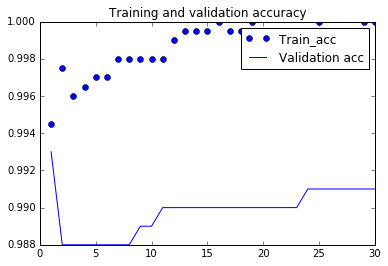

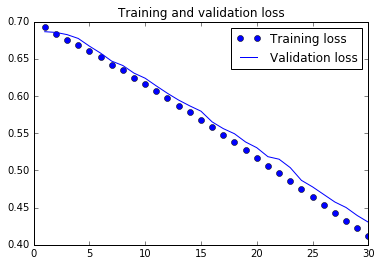

In [5]:
# 绘制曲线
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,"bo",label = "Train_acc")
plt.plot(epochs,val_acc,"b",label = "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs,loss,"bo",label = "Training loss")
plt.plot(epochs,val_loss,"b",label= "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()